## Table of contents :
* [I - Preprocessing](#first)
    * [1 - Filter tokens by token length](#first_1)
    * [2 - Filter questions with underpopulated classes](#first_2)
    * [3 - Split training & testing sets (tags as target)](#first_3)
* [II - Modelization](#second)
    * [1 - Unsupervised method (TF-IDF + LDA)](#second_1)
        * [1.1 - TF-IDF](#second_1_1)
        * [1.2 - Topic Modeling (LDA)](#second_1_2)
    * [2 - Supervised method (TF-IDF + SVM)](#second_2)
        * [2.1 - Dummy Classifier](#second_2_1)
        * [2.2 - Linear SVM](#second_2_2)
    * [3 - Semi-supervised method (Word2Vec + GRU)](#second_3) 
        * [3.1 - Word2Vec](#second_3_1)
        * [3.2 - GRU](#second_3_2)
* [III - Hyperparameters optimization methods](#third)
    * [1 - Grid search](#third_1)
    * [2 - Bayesian optimization](#third_2)

In [1]:
import sys
sys.path.append("..")
# Preprocessing
import itertools
from scipy.sparse import hstack
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from src.datacleaner import *   # Personal package named src
#from src.preprocessor import *  # Data preprocessing
from src.nlp.text_preprocessor import *  # Text data preprocessing
# EDA
from src.analyzer.univariate import *
from src.analyzer.multivariate import *
# Text classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from src.nlp.dnn import DNN
from src.nlp.topic_modeling import TopicModeling
# Model evaluation
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from src.nlp.text_classifier_evaluator import evaluate_text_classifier
# from src.evaluator import *
from utils.autotagger import *
# import logging
%matplotlib inline
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.6/dist-packages/spacy/util.py:271: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import modelization dataset 
df = pd.read_csv('data/csv/questions_modelization_dataset_413t.csv',
                 converters={col: eval for col in ['QuestionTokens', 'Tags']})

# Sample used to perform multiple tests to find optimal parameters with grid search
# df = df.sample(frac=0.5, random_state=42)

tokens_col = 'QuestionTokens'

# Extract tags
tags = list(set([tag for tags in df['Tags'] for tag in tags]))

# Save tags
# pickle_data(filename='tags',
#             data=tags,
#             folder='../data/preprocessing',
#             method='w')

# Dataset shape
print('Rows : {0}\nColumns : {1}'.format(read_int_cleaner(df.shape[0]), df.shape[1]))

Rows : 271 387
Columns : 3


# I - Preprocessing <a class="anchor" id="first"></a>

## 1 - Filter tokens by token length <a class="anchor" id="first_1"></a>

In [3]:
# Tokens mean length descriptive statistics
tokens_mean_length_df = df[tokens_col].map(lambda tokens: sum([len(token) for token in tokens])/len(tokens))
tokens_mean_length_df.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
QuestionTokens,271387.0,6.241043,0.887698,1.448735,5.663471,6.116071,6.666667,45.761261


In [4]:
# Display outliers
outlier_thr = np.floor(tokens_mean_length_df.describe().to_frame().T['max']).iloc[0]
df[tokens_mean_length_df > outlier_thr].QuestionTokens.iloc[0]

['navbar',
 'changes',
 'alignment',
 'page',
 'content',
 'toggled',
 'website',
 'developing',
 'need',
 'implement',
 'navbar',
 'placed',
 'right',
 'pushes',
 'page',
 'content',
 'left',
 'toggled',
 'reveal',
 'navbar',
 'content',
 'problem',
 'glitch',
 'toggle',
 'clicked',
 'close',
 'navbar',
 'pushes',
 'entire',
 'content',
 'website',
 'right',
 'content',
 'needs',
 'toggle',
 'clicked',
 'code',
 'doctype',
 'lang',
 'head',
 'required',
 'meta',
 'tags',
 'meta',
 'charset',
 'utf',
 'meta',
 'viewport',
 'content',
 'width',
 'device',
 'width',
 'initial',
 'scale',
 'shrink',
 'fit',
 'bootstrap',
 'link',
 'rel',
 'stylesheet',
 'href',
 'https',
 'stackpath',
 'bootstrapcdn',
 'com',
 'bootstrap',
 'css',
 'bootstrap',
 'min',
 'css',
 'integrity',
 'sha',
 'ggoyrixcbmqvxipmamd',
 'jcy',
 'ijtquohcwrxjvorxtmzwt',
 'crossorigin',
 'anonymous',
 'head',
 'body',
 'div',
 'class',
 'navbar',
 'sticky',
 'img',
 'src',
 'img',
 'vamos',
 'black',
 'png',
 'alt',
 'wi

In [5]:
# Tag length descriptive statistics 
tags_df = pd.DataFrame({'Tags': tags, 'Length': [len(tag) for tag in tags]})
tags_df.describe().T.astype(int)

,count,mean,std,min,25%,50%,75%,max
Length,413,8,4,1,5,7,11,26


In [6]:
# Filtering tokens that are longer than the longest tag (outliers)
tags_max_length = tags_df.Length.max()
df[tokens_col] = df[tokens_col].map(lambda tokens: [token for token in tokens if len(token) <= tags_max_length])

## 2 - Filter questions with underpopulated classes <a class="anchor" id="first_2"></a>

In [7]:
%%time

# Keep current dataframe state (rows count)
original_rows_count = df.shape[0]
# Filter questions which have underpopulated classes
df = filter_underpopulated_classes(df, 'Tags')
# Estimate data loss
get_data_loss(df, original_rows_count)

Dataframe rows reduced by 9.5 % (271387 -> 245687)
CPU times: user 7min 40s, sys: 44.8 ms, total: 7min 41s
Wall time: 7min 41s


In [8]:
# Get vocabulary size (total & unique counts)
main_vocabulary = [token for tokens in df[tokens_col] for token in tokens]
vocabulary_size = len(main_vocabulary)
vocabulary_set_size = len(set(main_vocabulary))
print('Vocabulary Size :\n')
print(f'- Total = {read_int_cleaner(vocabulary_size)} words\n')
print(f'- Unique = {read_int_cleaner(vocabulary_set_size)} words')
print(f'- Total tags in corpus = {read_int_cleaner(len([w for w in main_vocabulary if w in tags]))} words')

Vocabulary Size :

- Total = 29 114 093 words

- Unique = 604 670 words
- Total tags in corpus = 3 197 011 words


## 3 - Split training & testing sets (tags as target) <a class="anchor" id="first_3"></a>

In [9]:
# Transform tags (list of keywords) as multi label binarized numpy array
multilabel_encoder = MultiLabelBinarizer(sparse_output=False)
target = multilabel_encoder.fit_transform(df['Tags'])

# Save multi label binarized instance
# pickle_data(filename='multilabel_encoder',
#             data=multilabel_encoder,
#             folder='../data/preprocessing',
#             method='w')

# Split training & testing sets
X_train, X_test, y_train, y_test = train_test_split(df[tokens_col],
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=target) # Stratify K tags (target)

print('Training set : {} rows\n'.format(read_int_cleaner(X_train.shape[0])))
print("Testing set : {} rows".format(read_int_cleaner(X_test.shape[0])))

Training set : 196 549 rows

Testing set : 49 138 rows


# II - Modelization <a class="anchor" id="second"></a>

## 1 - Unsupervised method (TF-IDF + LDA) <a class="anchor" id="second_1"></a>

### 1.1 - TF-IDF <a class="anchor" id="second_1_1"></a>

In [10]:
# Main data
input_data = {'train': X_train,
              'test': X_test}

# identity tokenizer
def identity_tokenizer(token): return token

# unigram TF-IDF parameters
unigram_tfidf_params = {'tokenizer': identity_tokenizer, 
                        'stop_words': None,
                        'lowercase': False,
                        'token_pattern': r"(?u)\S\S+", # keep tag pattern (c++, python-3.7 etc ...)
                        'max_features': round(vocabulary_set_size*0.1), # 379 915 words
                        'max_df': 1.0,
                        'min_df': 0.0}

# # trigrams TF-IDF parameters
# trigrams_tfidf_params = {'tokenizer': identity_tokenizer,
#                          'stop_words': None,
#                          'lowercase': False,
#                          'token_pattern': r"(?u)\S\S+", # keep tag pattern (c++, python-3.7 etc ...)
#                          'ngram_range': (3, 3),
#                          'max_features': round(379915*0.28),
#                          'max_df': 1.0,
#                          'min_df': 0.0}


# Train unigram TF-IDF 
X_unigram_tfidf_train, X_unigram_tfidf_test, unigram_tfidf = text_vectorizer(input_data,
                                                                             unigram_tfidf_params,
                                                                             vectorizer_type='tfidf',
                                                                             return_model=True)
# Train trigrams TF-IDF 
# X_trigrams_tfidf_train, X_trigrams_tfidf_test, trigrams_tfidf = text_vectorizer(input_data,
#                                                                                 trigrams_tfidf_params,
#                                                                                 vectorizer_type='tfidf',
#                                                                                 return_model=True)

# Stack TF-IDF vectorizers (unigram & trigrams) training & testing outputs
X_train_vectorized = X_unigram_tfidf_train # hstack((X_unigram_tfidf_train, X_trigrams_tfidf_train)).tocsr()
X_test_vectorized = X_unigram_tfidf_test # hstack((X_unigram_tfidf_test, X_trigrams_tfidf_test)).tocsr()

# Save unigram & trigrams TF-IDF models
pickle_data(filename='tfidf_vectorizer',
            data=unigram_tfidf, # [unigram_tfidf, trigrams_tfidf],
            folder='data/models')

### 1.2 - Topic Modeling (LDA) <a class="anchor" id="second_1_2"></a>

#### 1.2.1 - Find optimal number of topics

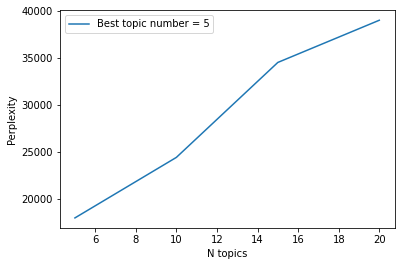

CPU times: user 31min 23s, sys: 13.2 s, total: 31min 36s
Wall time: 31min 29s


In [11]:
%%time 

# e.g. : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

lda_params = {'max_iter': 5,
              'learning_method': 'online',
              'learning_offset': 50.,
              'random_state': 42}

tm = TopicModeling('lda', lda_params, module_type='sklearn')

tm.plot_optimal_topic_number(X_train_vectorized,
                             X_test_vectorized,
                             max_topics=25,
                             metric='perplexity',
                             step=5,
                             tokens=X_train,
                             vectorizer=unigram_tfidf) # [unigram_tfidf, trigrams_tfidf]

#### 1.2.2 - Train LDA

In [12]:
%%time


lda_params['n_components'] = tm.optimal_topic_number

tm = TopicModeling('lda',
                   lda_params,
                   module_type='sklearn')

tm.fit(X_train_vectorized)

CPU times: user 4min 34s, sys: 638 ms, total: 4min 35s
Wall time: 4min 35s


In [13]:
tm.display_LDAvis(X_train_vectorized,
                  unigram_tfidf, # [unigram_tfidf, trigrams_tfidf],
                  n_top_words=10)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.161944 -0.031018       1        1  43.257743
0     -0.199354  0.080013       2        1  22.326224
2     -0.139417 -0.045910       3        1  21.829888
3      0.236909 -0.198567       4        1   7.215939
1      0.263806  0.195482       5        1   5.370206, topic_info=            Term         Freq        Total Category  logprob  loglift
27013       java  1535.000000  1535.000000  Default  10.0000  10.0000
14242        div  2485.000000  2485.000000  Default   9.0000   9.0000
41476     public  1944.000000  1944.000000  Default   8.0000   8.0000
1984     android  1514.000000  1514.000000  Default   7.0000   7.0000
8208       class  3054.000000  3054.000000  Default   6.0000   6.0000
...          ...          ...          ...      ...      ...      ...
8138        city   200.772727   296.738331   Topic5  -5.5481   2.5336
35009      nginx   168.606864   213.258386   Topic5  -5.7227   2.6894
32130  microsoft   251.007148   468.024557   Topic5  -5.3248   2.3013
57470        vec   182.937945   264.634591   Topic5  -5.6411   2.5551
10027  container   227.406609   771.460095   Topic5  -5.4235   1.7028

[126 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1984       1  0.099018  android
1984       3  0.473305  android
1984       4  0.427097  android
2180       5  0.994653  ansible
2306       1  0.863393      api
...      ...       ...      ...
57794      1  0.245080     view
57794      3  0.754091     view
58861      3  0.996463   widget
58876      2  0.054773    width
58876      3  0.944563    width

[222 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 2])

#### 1.2.3 - Build topics distribution by documents (questions)

In [14]:
# Create Document — Topic Matrix
doc_topic_distr = tm.model.transform(X_test_vectorized)

# topic names (columns)
topic_names = ['Topic_{}'.format(i+1) for i in range(tm.model.n_components)]

# document names (index)
doc_names = ['Doc_{}'.format(i+1) for i in range(len(X_test))]

# Make the pandas dataframe
df_doc_topic = pd.DataFrame(np.round(doc_topic_distr, 2), columns=topic_names, index=doc_names)

# Get main topics by documents (questions)
col_names = {doc: [] for doc in doc_names}
for doc, data in df_doc_topic.iterrows():
    for topic, x in data.iteritems():
        if x > 0.1:
            col_names[doc].append(int(topic.replace('Topic_', '')))
            
df_doc_topic["Main_topic(s)"] = df_doc_topic.index.map(col_names)

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(tm.model.components_ / tm.model.components_.sum(axis=1)[:, np.newaxis]) 
df_topic_keywords.columns = [w for w in unigram_tfidf.get_feature_names()]
df_topic_keywords.index = topic_names
df_topic_keywords.head(2)

,.htaccess,.net,.net-core,aab,aaba,aabb,aabbcc,aac,aacc,aaccfddecaaec,aad,aadd,aadinstance,aadsts,aae,aaefaff,aaf,aah,aan,aantal,aap,aapl,aapt,aaptdaemon,aaptdaemonimpl,aaptinternalexception,aar,aarch,aardvark,aaron,aas,aat,aatrox,aawyp,aba,abaa,abab,ababa,ababab,abacus,...,zscore,zsh,zshrc,zsize,zst,zstack,zstcout,zstd,zstgetilmedlmeert,zstl,ztanpfmrkuzfbdtjw,zulh,zulu,zulufx,zum,zur,zurich,zuul,zval,zvbi,zvg,zvp,zvxgp,zwei,zxc,zxcv,zxid,zxing,zxingscannerview,zygote,zygoteinit,zyx,zza,zzairas,zzb,zzc,zzf,zzi,zziplib,zzkt
Topic_1,8.612153e-07,8.637871e-07,8.602212e-07,0.000016,0.000001,0.000017,0.000010,9.392885e-07,8.796954e-07,8.609427e-07,8.690174e-07,0.000005,8.593438e-07,8.593911e-07,9.270978e-07,8.596176e-07,0.000003,0.000002,9.699258e-07,8.604421e-07,0.000009,0.000082,8.609418e-07,8.594228e-07,8.594460e-07,8.593868e-07,8.616606e-07,8.605008e-07,0.000016,0.000011,0.000009,0.000004,0.000010,9.110734e-07,0.000025,8.595227e-07,0.000017,0.000003,0.000009,0.000001,...,0.000017,8.622717e-07,8.598301e-07,8.610277e-07,8.599700e-07,8.594635e-07,8.602124e-07,8.814439e-07,8.594230e-07,8.593495e-07,8.607526e-07,8.601464e-07,9.391931e-07,8.593848e-07,0.000001,9.630798e-07,0.000004,8.596874e-07,0.000005,8.608620e-07,8.598255e-07,8.595136e-07,8.598255e-07,8.792403e-07,0.000009,8.725295e-07,8.593949e-07,8.605707e-07,8.593525e-07,8.628986e-07,8.593860e-07,0.000002,8.671690e-07,8.894629e-07,8.594208e-07,8.593389e-07,8.593335e-07,8.594500e-07,8.608620e-07,8.597860e-07
Topic_2,5.700881e-06,2.152954e-03,2.391061e-05,0.000006,0.000006,0.000032,0.000031,5.961201e-06,2.947971e-05,5.705705e-06,5.923577e-06,0.000006,2.349641e-05,1.836853e-04,6.618305e-06,5.695279e-06,0.000006,0.000006,5.941499e-06,5.696783e-06,0.000006,0.000006,5.713296e-06,5.687240e-06,5.688229e-06,5.685899e-06,5.686206e-06,5.833507e-06,0.000006,0.000006,0.000006,0.000006,0.000006,2.066466e-05,0.000006,5.713731e-06,0.000006,0.000006,0.000006,0.000006,...,0.000006,5.696280e-06,5.698456e-06,5.706002e-06,2.573669e-05,5.683940e-06,1.307147e-05,5.811106e-06,6.633595e-06,6.489477e-06,5.692451e-06,5.721605e-06,5.819429e-06,5.684634e-06,0.000006,6.158338e-06,0.000006,2.502640e-04,0.000006,2.357673e-05,1.261225e-05,1.369541e-05,1.261225e-05,5.721113e-06,0.000006,5.688537e-06,5.687932e-06,5.780797e-06,5.684228e-06,5.701383e-06,5.683953e-06,0.000006,5.683832e-06,5.112620e-05,5.683713e-06,5.684405e-06,5.683532e-06,5.687819e-06,2.357673e-05,5.685892e-06


#### 1.2.4 - Assign tag to questions

In [15]:
n_tags = len(tags)
lda_scores = []
lda_tags = []
# Get token labels
token_names = df_topic_keywords.columns
# Get distribution over the words for each topic 
lda_components = tm.model.components_ / tm.model.components_.sum(axis=1)[:, np.newaxis]
# Find best tags
for topic_number in range(lda_params['n_components']):
    topic_score = doc_topic_distr[0][topic_number]
    for word_idx, word_score in zip(lda_components[topic_number].argsort()[-n_tags:],
                                    sorted(lda_components[topic_number])[-n_tags:]):
        score = topic_score*word_score
        # print(score, token_names[word_idx])
        if score >= 0.00001:
            lda_scores.append(score)
            lda_tags.append(token_names[word_idx])

results = list(set([tag for score, tag in sorted(zip(lda_scores, lda_tags), key=lambda pair: pair[0], reverse=True)]))
tags_from_results = len([w for w in results if w in tags])
print("{} words with {} from target tag list ({} %)".format(len(results),
                                                            tags_from_results,
                                                            round(tags_from_results/len(results)*100, 1)))


# Get main tags by topics (5 largest)

# tags_by_topic = {n+1: [] for n in range(len(df_topic_keywords.T.columns))}
# for topic in df_topic_keywords.T.columns:
#     for tag in df_topic_keywords.T.nlargest(5, topic).index:
#         # Decompose tri-grams
#         if ' ' in tag:
#             tags_by_topic[int(topic.replace('Topic_', ''))].extend(tag.split())
#         else:
#             tags_by_topic[int(topic.replace('Topic_', ''))].append(tag)

# df_doc_topic['tags'] = df_doc_topic["Main_topic(s)"].map(lambda n: set([i for x in n for i in tags_by_topic[x]]))
# # Use target to filter topic tags
# df_doc_topic['tags'] = df_doc_topic['tags'].map(lambda topic_tags: [tag for tag in topic_tags if tag in tags])
# # Evaluate LDA
# lda_pred = multilabel_encoder.transform(df_doc_topic['tags'])
# evaluate_text_classifier(y_test_sampled, lda_pred)

1401 words with 138 from target tag list (9.9 %)


## 2 - Supervised method (TF-IDF + SVM) <a class="anchor" id="second_2"></a>

### 2.1 - Dummy Classifier <a class="anchor" id="second_2_1"></a>

In [16]:
dummy_clf = OneVsRestClassifier(DummyClassifier(strategy='stratified', random_state=42))

dummy_clf.fit(X_train_vectorized, y_train)

y_pred_dummy_cls = dummy_clf.predict(X_test_vectorized)

evaluate_text_classifier(y_pred_dummy_cls, y_test)

,accuracy,precision,recall,f1-score,jaccard score
results,0.14,3.71,1.89,1.79,1.21


### 2.2 - Linear SVM <a class="anchor" id="second_2_2"></a>

#### 2.2.1 - Add quantitative features (from train & testing sets)

In [17]:
# quanti_cols = [
# #                'Score',
# #                'ViewCount',
# #                'CommentCount',
# #                'AnswerCount',
# #                'TitleLength',
# #                'BodyLength',
# #                'TotalTags',
# #                'TotalTokens',
# #                'UniqueTokens'
#                ]

# X_train_quanti = df[df.index.isin(X_train.index)].loc[:, quanti_cols]

# X_test_quanti = df[df.index.isin(X_test.index)].loc[:, quanti_cols]

# Standardize quantitative features (from train & testing sets)
# X_train_quanti_scaled, std_scaler = standard_scaler(X_train_quanti,
#                                                     return_std_scaler=True,
#                                                     rebuild_df=True)
# X_test_quanti_scaled = std_scaler.transform(X_test_quanti)

# Merge quantitative features with TF-IDF features (from train & testing sets)
# X_train_svm = hstack((X_train_vectorized, X_train_quanti_scaled)).tocsr()
# X_test_svm = hstack((X_test_vectorized, X_test_quanti_scaled)).tocsr()

#### 2.2.2 - Train linear SVM

In [17]:
%%time

svm_model = LinearSVC(random_state=42,
                      dual=True,
                      # multi_class='crammer_singer',
                      max_iter=10000)

svm = OneVsRestClassifier(svm_model) 

param_grid = {'estimator__C': [1]} # Best parameter selected from range : [1, 5, 10 ,100]

svm_gs = GridSearchCV(svm,
                      param_grid,
                      cv=10,
                      scoring='f1_samples')

svm_gs.fit(X_train_vectorized, y_train)

CPU times: user 52min 35s, sys: 9.97 s, total: 52min 45s
Wall time: 52min 46s


In [18]:
y_pred_svm = svm_gs.predict(X_test_vectorized)

evaluate_text_classifier(y_pred_svm, y_test)

,accuracy,precision,recall,f1-score,jaccard score
results,30.08,58.94,70.88,61.2,53.52


In [ ]:
# Plot training curve

# plot_validation_curve(svm,
#                       X_train_vectorized,
#                       y_train,
#                       'estimator__C',
#                       [1, 5, 10, 100],
#                       log_scale=False,
#                       scorer='f1_samples')

In [ ]:
# Save SVM model
# pickle_data(filename='svm_ovr',
#             data=svm_ovr,
#             folder='data/models')

## 3 - Semi-supervised method (Word2Vec + GRU) <a class="anchor" id="second_3"></a>

### 3.1 - Word2Vec <a class="anchor" id="second_3_1"></a>

#### 3.1.1 - Find optimal dense vector size 

In [19]:
# Estimate optimal Word2Vec dense vector size 
corpus_tokens_count = pd.Series(df[tokens_col].map(len)).describe().to_frame().T.astype(int)
corpus_tokens_count

,count,mean,std,min,25%,50%,75%,max
QuestionTokens,245687,118,139,3,50,82,136,3527


In [20]:
# Define Word2Vec dense vector size
w2v_dense_vector_size = 100

#### 3.1.2 - Find optimal window (maximum distance between the target word and its neighboring word)

In [21]:
def compute_domain_words_window(tokens, tags, verbose=False):
    indices = [i for i, token in enumerate(tokens) if token in tags]
    distances = [abs(c[1] - c[0]) for c in itertools.combinations(indices, 2)]
    if len(distances) > 0:
        mean_dist = sum(distances) / len(distances)
    else:
        mean_dist = 0.0
    if verbose:
        print([tokens[i] for i in indices])
        print(distances)
    return mean_dist


df['DomainWordsWindow'] = df[tokens_col].map(lambda tokens: compute_domain_words_window(tokens, tags))

df['DomainWordsWindow'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
DomainWordsWindow,245687.0,23.842996,45.247885,0.0,2.0,9.555556,28.624753,1298.17676


In [22]:
# Define Word2Vec dense vector size
w2v_window = 10

#### 3.1.3 - Find optimal minimium frequency count of words

In [23]:
# Compute main vocabulary frequency distribution
main_vocab_freq_dist = dict(nltk.FreqDist(main_vocabulary))
# Build main vocabulary frequency distribution dataframe
main_vocab_freq_dist_df = pd.DataFrame({'Words': main_vocab_freq_dist.keys(),
                                        'Frequency': main_vocab_freq_dist.values()})
# Sort main vocabulary distribution by frequency
main_vocab_freq_dist_df = main_vocab_freq_dist_df.sort_values(by='Frequency')
# Compute cumulative frequency
main_vocab_freq_dist_df['CumulativeFrequency'] = np.round(np.cumsum(main_vocab_freq_dist_df['Frequency']/
                                                           main_vocab_freq_dist_df['Frequency'].sum()), 3)
# Define threshold (ratio)
main_vocab_cumfreq_thr = 0.01 # 0.2
# Apply threshold to vocabulary cumulative frequency
main_vocab_thr_idx = np.min(np.where(main_vocab_freq_dist_df['CumulativeFrequency'] > main_vocab_cumfreq_thr))
# Define Word2Vec minimium frequency count of words
w2v_min_count = main_vocab_freq_dist_df.iloc[main_vocab_thr_idx]['Frequency']
w2v_min_count

2

#### 3.1.4 - Train Word2Vec

In [24]:
%%time

# Word2Vec parameter grid 

WORD2VEC_PARAMS = {# The size of the dense vector to represent each token or word
                   'size': w2v_dense_vector_size,
                   # The maximum distance between the target word and its neighboring word
                   'window': w2v_window,
                   # Number of iterations (epochs) over the corpus
                   'iter': 1, # (best 1) old : 25
                   # Minimium frequency count of words
                   'min_count': w2v_min_count,
                   # How many threads to use behind the scenes
                   'workers': 8
                   #'sample': 1e-3,
                  }

# Input data (tokens)
corpus = df[tokens_col].values

# Word2Vec model
w2v_model = gensim.models.Word2Vec(corpus, **WORD2VEC_PARAMS)

# Train Word Embeddings
w2v_model.train(corpus,
                total_examples=len(corpus),
                epochs=w2v_model.epochs)

print("Total word vectors : {}".format(read_int_cleaner(len(w2v_model.wv.vocab))))

# Save trained embeddings
# w2v_model.save('../data/models/stackoverflow_word2vec_embeddings.bin')

# Load pre-trained embeddings
# w2v_model = gensim.models.word2vec.Word2Vec.load('../data/models/stackoverflow_word2vec_embeddings.bin')

Total word vectors : 379 915
CPU times: user 4min 5s, sys: 928 ms, total: 4min 6s
Wall time: 2min 39s


In [25]:
# Testing Word Embeddings
w2v_test_tags = ['python',
                 'pandas',
                 'keras',
                 'tensorflow',
                 'django',
                 'flask',
                 'git',
                 'api',
                 'sql',
                 'c',
                 'c++']

for tag in w2v_test_tags:
    print(f'{tag} most similar terms : \n{w2v_model.wv.most_similar(tag)}')
    print('--------------------------------------------------------------------')

python most similar terms : 
[('packages', 0.6287466883659363), ('line', 0.6179832220077515), ('site', 0.6032133102416992), ('anaconda', 0.5898193717002869), ('numpy', 0.5760607123374939), ('django', 0.5701931715011597), ('venv', 0.563947319984436), ('pythonoperator', 0.561847448348999), ('usr', 0.5513443350791931), ('virtualenv', 0.5512422323226929)]
--------------------------------------------------------------------
pandas most similar terms : 
[('dataframe', 0.7531862854957581), ('nambu', 0.7109076976776123), ('numpy', 0.6541777849197388), ('reindex', 0.6527289152145386), ('nans', 0.6469622254371643), ('fillna', 0.6317000985145569), ('rangeindex', 0.6281493902206421), ('panda', 0.6127041578292847), ('iloc', 0.6114979386329651), ('nlargest', 0.6105790138244629)]
--------------------------------------------------------------------
keras most similar terms : 
[('tensorflow', 0.7646890878677368), ('resnet', 0.7387967109680176), ('inceptionv', 0.7287541627883911), ('pretrained', 0.72354

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### 3.2 - GRU <a class="anchor" id="second_3_2"></a>

#### 3.2.1 - Preprocessing

In [26]:
# Total tags
TAGS_SIZE = len(tags)

# Preprocessing text
ktp = KerasTextPreprocessor(corpus, tokenized=True)
# Tokenize corpus
ktp.tokenize_corpus(filters='', num_words=len(w2v_model.wv.vocab.keys()))
# Preprocess training & testing sets to sequences
X_train_padded, X_test_padded = [ktp.text_to_sequences(data, maxlen=w2v_model.vector_size) 
                                 for data in [X_train, X_test]]

#### 3.2.2 - Define metrics

In [27]:
# Metrics 
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall)/(precision + recall + K.epsilon())
    return f1_val

#### 3.2.3 - Train GRU

In [28]:
# Add dense layer

# Build Model
dnn = DNN(tokenizer=ktp.tokenizer, embedding_model=w2v_model, print_summary=True)
# Add Word2Vec embeddings
dnn.add_embedding_layer()
# Add GRU layer
dnn.add_GRU_layer(units=512,
                  return_sequences=False,
                  dropout=0.3,
                  recurrent_dropout=0.0)

num_neurons = 512*8
dnn.add_dense_layer(units=num_neurons, activation='relu')
dnn.add_dropout(0.3)
dnn.add_dense_layer(units=num_neurons, activation='relu') 
dnn.add_dropout(0.6)
# Target layer
dnn.add_dense_layer(units=TAGS_SIZE, activation='sigmoid')

dnn.compile_model(loss='binary_crossentropy',
                   optimizer=keras.optimizers.Adam(lr=0.0004),
                   metrics=['accuracy', f1_score])       

dnn_callbacks = [ # Reduce learning rate when a metric has stopped improving.
                  # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
                  ReduceLROnPlateau(monitor='val_loss',
                                    # number of epochs with no improvement 
                                    # after which learning rate will be reduced.
                                    patience=1),
                  ReduceLROnPlateau(monitor='val_accuracy', patience=1),
                  ReduceLROnPlateau(monitor='val_f1_score', patience=1),
                  # Stop training when a monitored metric has stopped improving.
                  # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
                  # EarlyStopping(monitor='val_f1_score',  
                  #               min_delta=1e-4, # Default accuracy precision
                  #               # Number of epochs with no improvement 
                  #               # after which training will be stopped.
                  #               patience=3)
                ]

dnn.fit(X_train_padded,
        y_train,
        batch_size=None,
        validation_data=(X_test_padded, y_test),
        epochs=4,
        callbacks=dnn_callbacks,
        verbose=1) 



# Evaluate model 
gru_2019_results = pd.DataFrame(dnn.evaluate(X_test_padded, y_test, return_dict=True),
                                index=['questions 2019'])

gru_2019_results

# Save model & tokenizer

# pickle_data(filename='GRU_tokenizer',
#             data=dnn.tokenizer,
#             folder='../data/preprocessing',
#             method='w')

# dnn.model.save('../data/models/stackoverflow_tag_predictor.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          37991600  
_________________________________________________________________
gru (GRU)                    (None, 512)               943104    
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 413)               1

,loss,accuracy,f1_score
questions 2019,0.007465,0.51972,0.713513


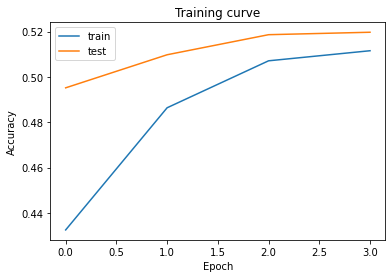

In [29]:
# Accuracy score training curve 
dnn.plot_training_curve(value_type='accuracy')

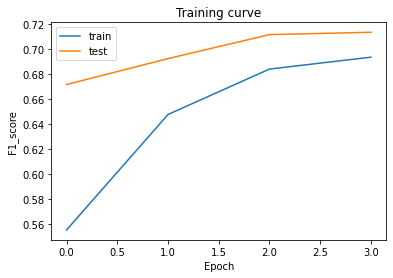

In [30]:
# F1 score training curve 
dnn.plot_training_curve(value_type='f1_score')

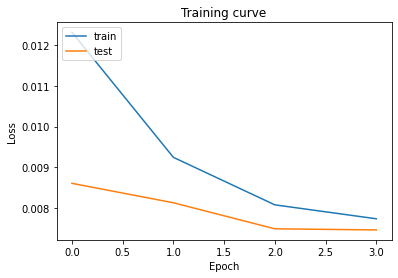

In [31]:
# Loss training curve
dnn.plot_training_curve(value_type='loss')

#### 3.2.4 - Evaluate with 2020 validation dataset


#### 2020 validation set

In [32]:
df_2020 = pd.read_csv('validation_set_2020.csv',
                      converters={col: eval for col in [tokens_col, 'Tags']}) #data/csv/
# Preprocess features
df_2020[tokens_col] = df_2020[tokens_col].map(lambda tokens: 
                                              [token for token in tokens if len(token) <= tags_max_length])

# Preprocess target

# Keep current dataframe state (rows count)
original_rows_count_df_2020 = df_2020.shape[0]
# Filter questions which have underpopulated classes
df_2020 = filter_underpopulated_classes(df_2020, 'Tags')
# Estimate data loss
get_data_loss(df_2020, original_rows_count_df_2020)
# Binarize target
target_2020 = multilabel_encoder.fit_transform(df_2020['Tags'])
# Preprocess validation sets to sequences
X_val_2020 = ktp.text_to_sequences(df_2020[tokens_col], maxlen=w2v_model.vector_size)

# Build 2020 evaluation dataframe results 
gru_2020_results = pd.DataFrame(dnn.evaluate(X_val_2020, target_2020, return_dict=True, verbose=0),
                                index=['questions 2020'])
gru_2020_results

Dataframe rows reduced by 10.8 % (198630 -> 177210)


,loss,accuracy,f1_score
questions 2020,0.007637,0.509029,0.717707


In [ ]:
# gru = keras.models.load_model('../data/models/stackoverflow_tag_predictor.h5', custom_objects={'f1_score': f1_score})

# III - Hyperparameters optimization methods <a class="anchor" id="third"></a>

## 1 - Grid search <a class="anchor" id="third_1"></a>

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier


def build_text_cls_model(units_dense_layer_1, lstm_dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE+1,
                        output_dim=WORD2VEC_PARAMS['size'],
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False))
    # LSTM
    model.add(LSTM(TAGS_SIZE,
                   dropout=lstm_dropout_rate,
                   recurrent_dropout=recurrent_dropout_rate))
    model.add(Dense(units=units_dense_layer_1,
                    activation='relu'))
    model.add(Dense(TAGS_SIZE,
                    activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


lstm_params_grid = {"lstm_dropout_rate": [0.2],           
                    "units_dense_layer_1": [64, 128, 256, 512],               
                    "batch_size": [None, 64, 128],                         
                    "nb_epoch": [25]}                   
                    
lstm_model = KerasClassifier(build_fn=build_text_cls_model, verbose=0)

lstm_gs = GridSearchCV(estimator=lstm_model,
                       param_grid=lstm_params_grid,
                       n_jobs=-1,
                       cv=3)

lstm_gs.fit(X_train_padded, y_train)

# summarize results
test_score_means = lstm_gs.cv_results_['mean_test_score']
test_score_stds = lstm_gs.cv_results_['std_test_score']
params = lstm_gs.cv_results_['params']

# Print results
print("Best accuracy : {} using {}".format(lstm_gs.best_score_, lstm_gs.best_params_))
for mean, std, param in zip(test_score_means, test_score_stds, params):
    print(f"Mean accuracy = {mean} (σ = {std}) with : {param}")

## 2 - Bayesian optimization <a class="anchor" id="third_2"></a>

In [ ]:
import optuna
from optuna.integration import KerasPruningCallback
from keras.backend import clear_session


# Optuna objective function
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    # Preprocessing text
    ktp = KerasTextPreprocessor(corpus, tokenized=True)
    # Tokenize corpus
    ktp.tokenize_corpus(filters='', num_words=len(w2v_model.wv.vocab.keys()))
    # Preprocess training & testing sets to sequences
    X_train_padded, X_test_padded = [ktp.text_to_sequences(data, maxlen=w2v_model.vector_size) 
                                    for data in [X_train, X_test]]

    dnn = DNN(tokenizer=ktp.tokenizer, embedding_model=w2v_model, print_summary=True)
    # Add Word2Vec embeddings
    dnn.add_embedding_layer()
    # embedding_layer_spatial_dropout_rate = trial.suggest_uniform('spatial_dropout_1d', 0.0, 1.0)
    # dnn.model.add(keras.layers.SpatialDropout1D(embedding_layer_spatial_dropout_rate))
    
    # Find best RNN baseline between LSTM & GRU architectures
    text_classifier_name = trial.suggest_categorical('classifier', ['LSTM', 'GRU']) 
    main_layer_num_hidden = trial.suggest_categorical('n_units', [512])
    # int(trial.suggest_loguniform('n_units', y_train.shape[1], 512))
    main_layer_dropout_rate = trial.suggest_uniform('dropout', 0.0, 1.0)
    main_layer_recurrent_dropout_rate = trial.suggest_uniform('recurrent_dropout', 0.0, 1.0)
    
    if text_classifier_name == 'LSTM':
        dnn.model.add(keras.layers.LSTM(units=main_layer_num_hidden,
                                        dropout=main_layer_dropout_rate,
                                        recurrent_dropout=main_layer_recurrent_dropout_rate))
    else:
        dnn.model.add(keras.layers.GRU(units=main_layer_num_hidden,
                                       dropout=main_layer_dropout_rate,
                                       recurrent_dropout=0.0))
    # Add hidden layers
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        num_hidden = trial.suggest_categorical('n_units_l{}'.format(i+1), [1024*4])
        drop_out_rate = trial.suggest_uniform('dropout_rate_l{}'.format(i+1), 0.2, 0.6)
        dnn.add_dense_layer(units=num_hidden, activation='relu')
        dropout_cond = trial.suggest_categorical('Add_dropout_l{}'.format(i+1), ['Yes', 'No']) 
        if dropout_cond == 'Yes':
          dnn.add_dropout(dropout_rate=drop_out_rate)

    dnn.add_dense_layer(units=y_train.shape[1], activation='sigmoid')
    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)

    dnn.compile_model(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(lr=learning_rate),
                      metrics=['accuracy', f1_score]) 

    dnn.model.fit(X_train_padded,
                  y_train,
                  validation_data=(X_test_padded, y_test),
                  batch_size=None,
                  callbacks=[KerasPruningCallback(trial, "val_accuracy")],
                  epochs=3,
                  verbose=False) 
    # Evaluate the model accuracy on the validation set.
    score = dnn.model.evaluate(X_test_padded, y_test, verbose=0, return_dict=True)
    return score['f1_score']


study = optuna.create_study(direction="maximize",
                            pruner=optuna.pruners.MedianPruner()
                            # study_name='Stack-Overflow-Text-Classifier-Distributed-TPE'
                            ) # Distributed Optimization
                              # (e.g : https://optuna.readthedocs.io/en/stable/tutorial/004_distributed.html)
study.optimize(objective, n_trials=100, n_jobs=3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))